## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction 

The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision. 

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# The number of unique users in the dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
# The proportion of users converted.
len(df.query('converted == 1'))/len(df)

0.11965919355605512

In [6]:
# The number of times the new_page and treatment don't match.
# it can be treatment group but showing old page, or control group but showing new page. Add them together.
len(df.query('group == "treatment" and landing_page == "old_page"')) + len(df.query('group == "control" and landing_page == "new_page"'))

3893

In [7]:
# check any missing value
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> No roll has missing value.

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. It's better to drop them.

In [8]:
# drop both group with mismatching landing page
df2 = df.drop(df.query('group == "treatment" and landing_page == "old_page"').index)
df2 = df2.drop(df.query('group == "control" and landing_page == "new_page"').index)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [9]:
# number of rolls after droping mismatching rolls
len(df2)

290585

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Remove one of the rows with a duplicate user_id, but keep dataframe as df2.
df2 = df2.drop_duplicates(subset='user_id')

In [15]:
# See if any duplicated rows after droping. It should be zero.
df2['user_id'].duplicated().sum()

0

What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2[df2['group']=='control'].converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2[df2['group']=='treatment'].converted.mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [19]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

 > No, there is no sufficient evidence to support a conclusion that the new page lead to higher conversion rate. The conversion rate are 12% and 11.9% for the control group and treatment group respectively. It colud be said that we got almost the same result from those two groups by looking at the sample data. We couldn't make a definate conclusion for which group being better. Therefore, we need to do the A/B test for an accurate answer.

<a id='ab_test'></a>
### Part II - A/B Test

For now, consider you need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be? 

> H0: P_new - P_old <= 0
>
> H1: P_new - P_old > 0

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
# Assume that the rate is equal to the converted rate in sample dataset
p_new = df2['converted'].mean()
p_new

0.11959708724499628

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
# Assume that conversion rate of p_new and p_old are equal
p_old = df2['converted'].mean()
p_old

0.11959708724499628

What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = len(df2.query('group == "control"'))
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# randomly choose from 0 and 1 for 145310 times with weight calculated from conversion rate for p_new
new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# randomly choose from 0 and 1 for 145274 times with weight calculated from conversion rate for p_old
old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# find the mean difference between conversion rate of new and old page
new_page_converted.mean() - old_page_converted.mean()

0.0017253096897818926

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# repeat steps of part e-g for 10000 times iteration and store the results in p_diffs
p_diffs = []
count = 0
while count < 10000:
    new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old,p_old])
    diffs = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diffs)
    count += 1

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

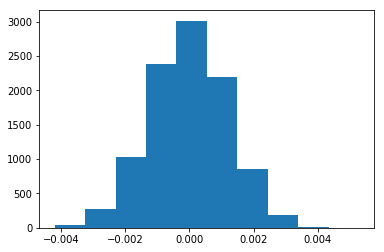

In [28]:
plt.hist(p_diffs)
plt.show()

> Under Central Limit Theorem, values show normal distribution as we have enough large sample size.

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

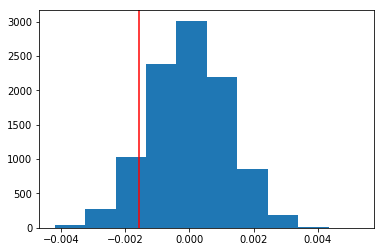

In [29]:
# Calculate the observed value and show it on the histogram as a red line
obs_diff = df2[df2['group']=='treatment'].converted.mean() - df2[df2['group']=='control'].converted.mean()

plt.hist(p_diffs)
plt.axvline(obs_diff, color="red")
plt.show()

In [30]:
p_diffs = np.array(p_diffs)
pval = (p_diffs > obs_diff).mean()
print('p-value: {}'.format(pval))
print('{}% of the p_diffs are greater than the observation difference in sample data.'.format(pval*100))

p-value: 0.9051
90.51% of the p_diffs are greater than the observation difference in sample data.


What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> Here I simulated the distribution of conversion rate difference between the contral and treatment group while the hypothsis null is true. By creating 10000 times iterations, under the Central Limit Theorem, we got large enough sample size and simulated a normal distribution. Since our alternative hypothesis is 'parameter > value', imply that this is a right-tailed test and the critial region is the shade on the right hand side of the critical value (obseration value). Suppose that the significance level for this test is 0.05, meaning that we have to reject the null hypothesis when p-value is less than 0.05. Lookng back to the histogram plot, p-value is now 0.91 which is much lager than 0.05. In this situation, we do not reject null hypothesis.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = len(df2.query('group == "control" and converted == 1'))
convert_new = len(df2.query('group == "treatment" and converted == 1'))
n_old = len(df2[df2['group']=='control'])
n_new = len(df2[df2['group']=='treatment'])

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
# Input the values calculated above to do the z-test to compute z score and p-value
nobs = np.array([n_new,n_old])
count = np.array([convert_new,convert_old])
z_score, pval = sm.stats.proportions_ztest(count, nobs, alternative = 'larger')
z_score, pval

(-1.3109241984234394, 0.90505831275902449)

What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> By using the built-in function we can compute the Z score and p-value at the same time. Z score is measure of standard deviation to decide whether or not to reject the null hypothesis, so we could say functionally it is same as p-value. The critical Z score values when using a 95% confidence level are -1.96 and +1.96 standard deviations. That being said, score higher than 1.96 or lower than -1.96 would be considered as very unlikely that the null hypothesis and observation value are from the same dataset, so null hypothesis should be rejected in favor of the alternative hypothesis. Here we got -1.31 Z score which is in between -1.96 and +1.96, imply than we should not reject the null hypothesis. P-value is almost the same as the one we calculated in part j. Both numbers agree with the findings in part j and k - conversion rate of old page is equal to or more than new page. 

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logistic Regression

The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# Create dummy for treatment group(new page)
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group']).treatment
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to instantiate regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-29 18:15 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

> The p-value associated with ab_page is 0.1899. The result is differ from the value we got in Part II because the hypotheses of two tests are different. In Part II, we were doing a right-tailed test with setting up hypothesis as (H0: P_new - P_old <= 0, H1: P_new - P_old > 0). Area on the right hade side of the observation value is counted. In this part, hypothesis is set up as (H0: P_new - P_old = 0, H1: P_new - P_old ≠ 0) so the test become a two-sided test. Let's see if we use the function in Part II to compute the p-value but change the alternative to "two-sided":

In [36]:
nobs = np.array([n_new,n_old])
count = np.array([convert_new,convert_old])
z_score, pval = sm.stats.proportions_ztest(count, nobs, alternative = 'two-sided')
pval

0.18988337448195103

> You can see the p-value is same as the one in this part (0.1899) since the hypothesis is changed.

Now, I am considering other things that might influence whether or not an individual converts.  Here I will discuss why it is a good idea to consider other factors to add into your regression model and also explain are there any disadvantages to adding additional terms into your regression model.

> Sometimes it is a good idea adding other factors to the regression model. It allows you to determine to what extent a number of factors may influence or associate with the dependent variable so we are able to reveal hidden or latent relationships between the variables in the dataset. In this case, one who converts or not may be affected by serveral factors such as age, gender or nationality. By adding them into the test, we may find out which independent varibale asoociated with the dependent variable (conversion) the most when other factors remain unchanged. 
> 
> However, adding new variables can make the model worse. One of a very typical problems called multicollinearity, which means independent variables in a regression model are correlated. The idea of regression test is to isolate the relationship between each independent variable. We are supposed to see how the dependent variable is influenced when a independent variable changes while other variables not. If independent variables are correlated, it indicates that changes in one variable may cause shifts in another variable. It becomes difficult to estimate the relationship between each independent variable because a change of a variable would drive up or down of other variables as well. 

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. I will read in the **countries.csv** dataset and merge together the datasets on the appropriate rows.

Does it appear that country had an impact on conversion? 

In [37]:
# Read the countries csv file and merge it with df2 on user_id
df_country = pd.read_csv('countries.csv')
df2 = df2.merge(df_country, how='left', on='user_id')
df2.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [38]:
# Check how many countries and what they are
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [39]:
# Create dummies for the Canada and UK. US will be the baseline so dummy is not needed. 
df2['CA_user'] = pd.get_dummies(df2['country']).CA
df2['UK_user'] = pd.get_dummies(df2['country']).UK
df2.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA_user,UK_user
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [40]:
# Run Logistic Regression test by adding Canada and UK users as indepentent variables, US user as baseline in this case
model = sm.Logit(df2['converted'], df2[['intercept', 'CA_user', 'UK_user']])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-29 18:15 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA_user      -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK_user       0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

> Country of users were added to the regression model to see whether different countries are associated with changes in conversion. All the p-values are higher than the significance level (0.05), indicate that there is no association between the changes in the independent variable and the shifts in the dependent variable, which is, no significant evidence to conclude that users from Canada or UK would cause difference on conversion while taking US user as the reference group.

We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and the conclusions based on the results.

In [41]:
# Create variables which representing interaction between page and Canada/UK. US again is the baseline so dummy is not needed.
df2['CA_page'] = df2['CA_user']*df2['ab_page']
df2['UK_page'] = df2['UK_user']*df2['ab_page']
df2.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA_user,UK_user,CA_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,1,0


In [42]:
# Run Logistic Regression test by adding interaction between Canada/UK users and new page
model = sm.Logit(df2['converted'], df2[['intercept', 'CA_page', 'UK_page']])
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-29 18:15 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_page      -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_page       0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

> By the above Logistic Regression model, we would like to know to what extent an interaction between new page and country may affect indivitual conversion. Though from the result we found that p-value of interaction of Canada and new page is statistically significant (0.0458 < 0.05) and it indicates we have enough evidence to reject null hypothesis, we have to aware that this is only statistically significant. If we compute the odds ratio by taking the estimated coefficients:

In [43]:
print('CA_page: {}'.format(np.exp(result.params).CA_page))
print('UK_page: {}'.format(np.exp(result.params).UK_page))

CA_page: 0.9275786675680885
UK_page: 1.0149999015298603


> Negative coefficients in a logistic regression model means that the probability of event happening of dependent variable is reduced when the value of independent variable increases. Here with US-new page as the reference level, the result indicates that Canada users landing on new page have a lower probability of conversion (0.93 times of US-new page users). Though the p-value of Canada new page users is statistically significant, we should not introduce the new page since it is not pratical significant.

## Conclusion

No matter doing A/B test by manual cauculating or build-in function, or doing Logistic Regression model with different independent variables, we can still sum up a conclution that null hypothesis is not statistically significant so we are fail to reject null hypothesis since we do not have strong enough evidence to do so. The result provide support for sticking with the old page. We should also aware that sometimes the results are only statistically significant. We should also look at practical significance to see the magnitude and possible nagetive of the difference before we make the decison.

## References

Thanks to the following pages to help me in solving tasks in the project:

> Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython. O'Reilly Media, Inc. Wes McKinney(2017)
>
> https://stackoverflow.com/
>
> https://www.geeksforgeeks.org/
>
> https://www.kite.com/python
>
> https://statisticsbyjim.com/hypothesis-testing/
>
> https://online.stat.psu.edu/statprogram/reviews/statistical-concepts/hypothesis-testing
>
> https://data-flair.training/blogs/python-statistics/

These book and sites bisically solve all the difficulties. Awesome! 